In [1]:
# import libraries
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import GridSearchCV # for tuning parameter
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

from sklearn.metrics import accuracy_score, f1_score, recall_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [179]:
df = pd.read_csv('Data\online_shoppers_intention_cleaned.csv', index_col=0)

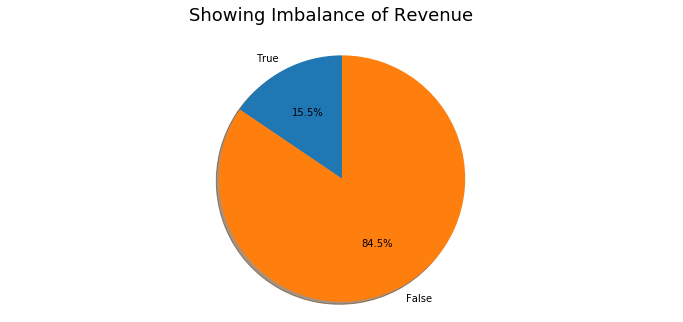

In [4]:
fig, ax = plt.subplots( figsize = (12,5))
plt.suptitle('Showing Imbalance of Revenue', fontsize = 18)
plt.pie([df[df['Revenue']==1].Revenue.count(), df[df['Revenue']==0].Revenue.count()], labels = ['True', 'False'],shadow=True, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [5]:
df.sample(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Season,Product_Duration,Special
8315,0.0,0.000,0.0,0.0,1.0,0.000000,0.2,0.200000,0.00000,0.0,...,3,2,4,3,Returning_Visitor,False,0,Fall,0,0
8957,9.0,739.125,0.0,0.0,19.0,1655.190476,0.0,0.022667,27.97007,0.0,...,1,1,7,2,New_Visitor,False,0,Fall,3,0


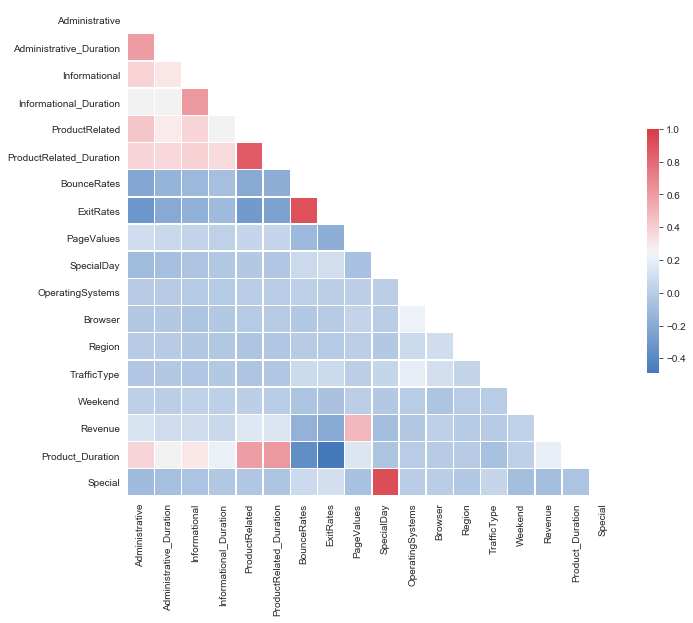

In [6]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


CorrMtx(df.corr(), dropDuplicates = True)

In [7]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue', 'Season', 'Product_Duration', 'Special'],
      dtype='object')

In [8]:
visitor= {'Other':0, 'New_Visitor':1, 'Returning_Visitor':2}
df['VisitorType'] = df['VisitorType'].map(visitor)

In [9]:
season= {'Winter':0, 'Spring':1, 'Summer':2, 'Fall':3}
df['Season'] = df['Season'].map(season)

In [10]:
df['Weekend'] = np.where(df['Weekend'] ==True, 1, 0)

In [11]:
df.Month.value_counts()

May     3357
Nov     2995
Mar     1884
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      431
June     288
Feb      171
Name: Month, dtype: int64

In [12]:
month = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

In [13]:
df['Month'] = df['Month'].map(month)

# Feature Selection

In [14]:
df_features= df.drop('Revenue', axis=1)

In [15]:
df_features

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Season,Product_Duration,Special
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,2,0,0,0,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,2,0,0,0,0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,2,0,0,0,0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,2,1,0,2,0
5,0.0,0.0,0.0,0.0,19.0,154.216667,0.015789,0.024561,0.000000,0.0,2,2,2,1,3,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,2,1,3,3,0
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,2,1,3,1,0
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,2,1,3,0,0
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,2,0,3,1,0


In [16]:
purchase=df[df['Revenue']==1]

In [17]:
purchase.groupby('TrafficType').Revenue.value_counts()

TrafficType  Revenue
1            1          262
2            1          847
3            1          180
4            1          165
5            1           56
6            1           53
7            1           12
8            1           95
9            1            4
10           1           90
11           1           47
13           1           43
14           1            2
16           1            1
19           1            1
20           1           50
Name: Revenue, dtype: int64

Let's start off with random features to see how we do!

In [18]:
features =['Season', 'Month', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Region', 
           'Browser', 'TrafficType']

In [19]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue', 'Season', 'Product_Duration', 'Special'],
      dtype='object')

In [20]:
from statsmodels.formula.api import ols

In [21]:
ols('Revenue~Season+Month+ProductRelated_Duration+BounceRates+ExitRates+PageValues+Region',data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     668.5
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:40:03   Log-Likelihood:                -2972.0
No. Observations:               12283   AIC:                             5960.
Df Residuals:                   12275   BIC:                             6019.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1367      0.014      9.508      0.000       0.109       0.165
Season                      0.0818      0.014      5.838      0.000       0.054       0.109
Month                      -0.0198      0.005     -4.114      0.000      -0.029      -0.010
ProductRelated_Duration  1.641e-05   1.52e-06     10.780      0.000    1.34e-05    1.94e-05
BounceRates                 0.6200      0.143      4.323      0.000       0.339       0.901
ExitRates                  -1.2981      0.146     -8.888      0.000      -1.584      -1.012
PageValues                  0.0090      0.000     58.903      0.000       0.009       0.009
Region                     -0.0025      0.001     -2.120      0.034      -0.005      -0.000
==============================================================================
Omnibus:                     3173.200   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10591.076
Skew:                           1.296   Prob(JB):                         0.00
Kurtosis:                       6.739   Cond. No.                     1.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue', 'Season', 'Product_Duration', 'Special'],
      dtype='object')

Making Dummy Variables for our categorical values

In [23]:
Special_dummies = pd.get_dummies(df.Special,prefix='Special', drop_first=True, )
ProductDur_dummies = pd.get_dummies(df.Product_Duration,prefix='Product_Duration', drop_first=True)
Month_dummies = pd.get_dummies(df.Month,prefix='Month', drop_first=True)
Season_dummies = pd.get_dummies(df.Season,prefix='Season', drop_first=True)
Browser_dummies = pd.get_dummies(df.Browser,prefix='Browser', drop_first=True)
Region_dummies = pd.get_dummies(df.Region,prefix='Region', drop_first=True)
VisitorType_dummies = pd.get_dummies(df.VisitorType,prefix='VisitorType', drop_first=True)
Weekend_dummies = pd.get_dummies(df.Weekend,prefix='Weekend', drop_first=True)

In [24]:
df = pd.concat([df, Special_dummies, ProductDur_dummies, Month_dummies, Season_dummies, Browser_dummies, Region_dummies, VisitorType_dummies, Weekend_dummies],axis=1)

In [25]:
df.drop(columns=['Special', 'Product_Duration', 'Month', 'Season', 'Browser', 'Region', 'VisitorType', 'Weekend'], inplace=True)

In [26]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('Revenue', axis = 1) # grabs everything else but 'Revenue'


# Create target variable
y = df['Revenue'] # y is the column we're trying to predict

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22,test_size=0.2)



In [28]:
scaler2 = StandardScaler()
# fit the scaler to the training data
scaler2.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=X.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=X.columns)

# Feature selection methods!

# Lasso

Let's start off with a Lasso

In [29]:
## training the model
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01, normalize=False)
lasso.fit(X_train,y_train)
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 0.20439605668951188
Testing Error: 0.29672916844733005


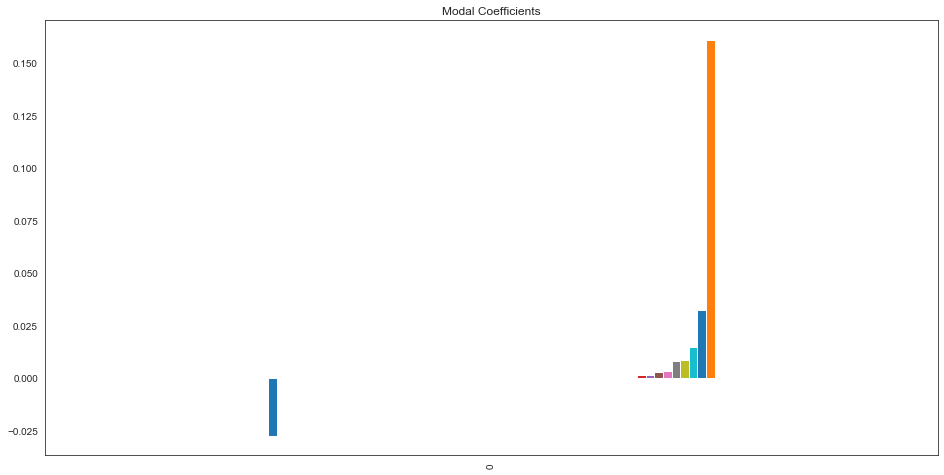

In [30]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [31]:
lasso_coef01.T

,0
ExitRates,-0.027464
SpecialDay,-0.000111
Month_12,-0.000000
Browser_2,-0.000000
Browser_3,-0.000000
Browser_4,0.000000
Browser_5,0.000000
Browser_6,-0.000000
Browser_7,0.000000
Browser_8,0.000000


# RFE

In [32]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [33]:
logreg = LogisticRegression()

In [34]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=logreg, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)




RFECV(cv=10, estimator=LogisticRegression(), scoring='neg_mean_squared_error')

In [35]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]



In [36]:
list(selected_rfe)

['ExitRates', 'PageValues', 'Month_11']

In [37]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
zip(X_train.columns, logreg.coef_[0])

RFE Only gave us 3 features 

## F -Test

In [38]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
selector = SelectKBest(f_regression, k='all')
selector.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_regression at 0x0000021C31013EE8>)

In [39]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
# X_train = X_train[selected_columns]
# X_test = X_test[selected_columns]

In [40]:
selected_columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'TrafficType', 'Special_1', 'Product_Duration_1',
       'Product_Duration_2', 'Product_Duration_3', 'Product_Duration_4',
       'Month_3', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'Season_1', 'Season_2', 'Season_3',
       'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6',
       'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11',
       'Browser_12', 'Browser_13', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'VisitorType_1', 'VisitorType_2', 'Weekend_1'],
      dtype='object')

# Modeling

# Logistical Regression without Class Balancing

In [109]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
feature_cols = [selected_columns]
X = X_train[selected_columns]
y = y_train
logreg.fit(X, y)

LogisticRegression(C=1000000000.0)

In [110]:
# upsampled_pred = upsampled_dt.predict(X_test)
logreg_pred = logreg.predict(X_test)
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, logreg_pred))
# checking accuracy
print('Test F1 score: ', f1_score(y_test, logreg_pred))

Test Accuracy score:  0.8603988603988604
Test F1 score:  0.6071019473081328


In [116]:
from sklearn import metrics
from sklearn.metrics import roc_curve,auc

In [117]:
fpr1,tpr1,thresh=roc_curve(y_test,logreg_pred)
auc1=auc(fpr1,tpr1)

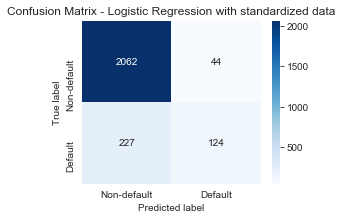

In [43]:
plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,logreg.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression with standardized data");

## SMOTE Logistic Regression

In [44]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=23)
X_train, y_train = sm.fit_sample(X_train[selected_columns], y_train)

In [45]:
smote_lr = LogisticRegression(solver='liblinear')

smote_lr.fit(X_train, y_train)

smote_pred = smote_lr.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, smote_pred))

Test Accuracy score:  0.8603988603988604
Test F1 score:  0.6071019473081328


In [118]:
fpr2,tpr2,thresh=roc_curve(y_test,smote_pred)
auc2=auc(fpr2,tpr2)

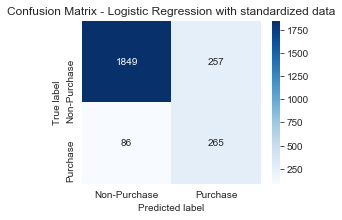

In [46]:
plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,smote_lr.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-Purchase', 'Purchase'], 
            yticklabels = ['Non-Purchase', 'Purchase'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression with standardized data");

## GridSearchCV with Balanced Class Weight Logistic Regression

In [96]:
estimator = LogisticRegression(random_state=1, class_weight='balanced')

In [98]:
param_grid = {
    'n_estimators' : [80,100,120,150],
    'max_depth' : [7,10,15,20],
    'min_samples_leaf' : [1,2,3,4],
    'min_samples_split': [2,4,6,8]
}

gridsearch = GridSearchCV(estimator=estimator,param_grid=param_grid,verbose = 1)
gridsearch.fit(X_train,y_train)

TypeError: __init__() missing 1 required positional argument: 'param_grid'

In [99]:
from sklearn.ensemble import VotingClassifier

In [100]:
C_param_range = [0.001,0.01,0.1,1,10]
titles = ['lr_0_001', 'lr_0_01', 'lr_0_1', 'lr_1', 'lr_10']
params = dict(zip(titles, C_param_range)) 
models = {}
table = pd.DataFrame(columns = ['C_parameter','F1'])
table['C_parameter'] = C_param_range
j = 0
for k , v  in params.items():
    # Create model using different value for c  
    lr = LogisticRegression(penalty = 'l2', C = v, random_state = 1, class_weight='balanced')
    #save the model to a dictionary to use later in our voting classifiers
    models[k]= lr
    #the steps below this point are unnecessary in order to create a voting classifier, 
    #but it is easy to fit the model and see how performance changes for different levels of regularization
    lr.fit(X_train, y_train)
    # Predict using model
    y_preds = lr.predict(X_test)
    # Saving accuracy score in table
    table.iloc[j,1] = metrics.f1_score(y_test, y_preds)
    j += 1

In [101]:
table

,C_parameter,F1
0,0.001,0.558333
1,0.010,0.593182
2,0.100,0.605714
3,1.000,0.607102
4,10.000,0.607102


In [103]:
lr_voting = VotingClassifier(estimators=list(models.items()), 
                              voting='hard')
lr_voting.fit(X_train, y_train)
lrv_preds = lr_voting.predict(X_test)
lrv_f1 = metrics.f1_score(y_test, lrv_preds)
print(lrv_f1)
print('Test Accuracy score: ', accuracy_score(y_test, lrv_preds))

0.6057142857142858
Test Accuracy score:  0.8595848595848596


In [120]:
fpr3,tpr3,thresh=roc_curve(y_test,lrv_preds)
auc3=auc(fpr3,tpr3)

## Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
rfc = RandomForestClassifier(random_state=1, class_weight='balanced')

In [86]:
#create a dictionary of all the parameters you want to tune
param_grid = { 
    'n_estimators': [800],
    'max_depth': [16,17,18,19],
    'max_features': [8],
    'criterion': ['gini'],
}

In [87]:
grid_tree=GridSearchCV(rfc, param_grid, cv=7, scoring='f1', verbose=2, n_jobs=-1)

{'criterion': 'gini', 'max_depth': 19, 'max_features': 8, 'n_estimators': 800}
RandomForestClassifier(class_weight='balanced', max_depth=19, max_features=8,
                       n_estimators=800, random_state=1)

In [93]:
X_train.shape{'criterion': 'gini', 'max_depth': 19, 'max_features': 8, 'n_estimators': 800}
RandomForestClassifier(class_weight='balanced', max_depth=19, max_features=8,
                       n_estimators=800, random_state=1)

(16538, 52)

In [89]:
# examine the best model
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)
# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)
# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.9362711327185892
{'criterion': 'gini', 'max_depth': 19, 'max_features': 8, 'n_estimators': 800}
RandomForestClassifier(class_weight='balanced', max_depth=19, max_features=8,
                       n_estimators=800, random_state=1)


In [122]:
#Predict the response for test dataset
rfc_preds = grid_tree.best_estimator_.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, rfc_preds))
print('Test Accuracy score: ', accuracy_score(y_test, rfc_preds))

F1: 0.6581306017925737
Test Accuracy score:  0.8913308913308914


In [125]:
fpr4,tpr4,thresh=roc_curve(y_test,rfc_preds)
auc4=auc(fpr4,tpr4)

## XG Boost Model

In [49]:
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score
import xgboost as xgb

In [50]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [51]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1, 
                           #scale_pos_weight= titanic['Survived'].mean(),
                           n_estimators = 10000)

In [52]:
xg_clf.fit(X_train,y_train)


XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [127]:
xg_preds = xg_clf.predict(X_test)


test_f1 = f1_score(y_test, xg_preds)
test_acc = accuracy_score(y_test, xg_preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.886854
F1: 0.594752


In [128]:
fpr5,tpr5,thresh=roc_curve(y_test,xg_preds)
auc5=auc(fpr5,tpr5)

## XG Boost with K-Fold cross Validation

In [54]:
data_dmatrix = xgb.DMatrix(data=X,label=y)



In [55]:
params = {"objective":"binary:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 3, 
          'alpha': 1}

cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=5,
                    num_boost_round=500,
                    early_stopping_rounds=5,
                    metrics="logloss", 
                    as_pandas=True, 
                    seed=123)

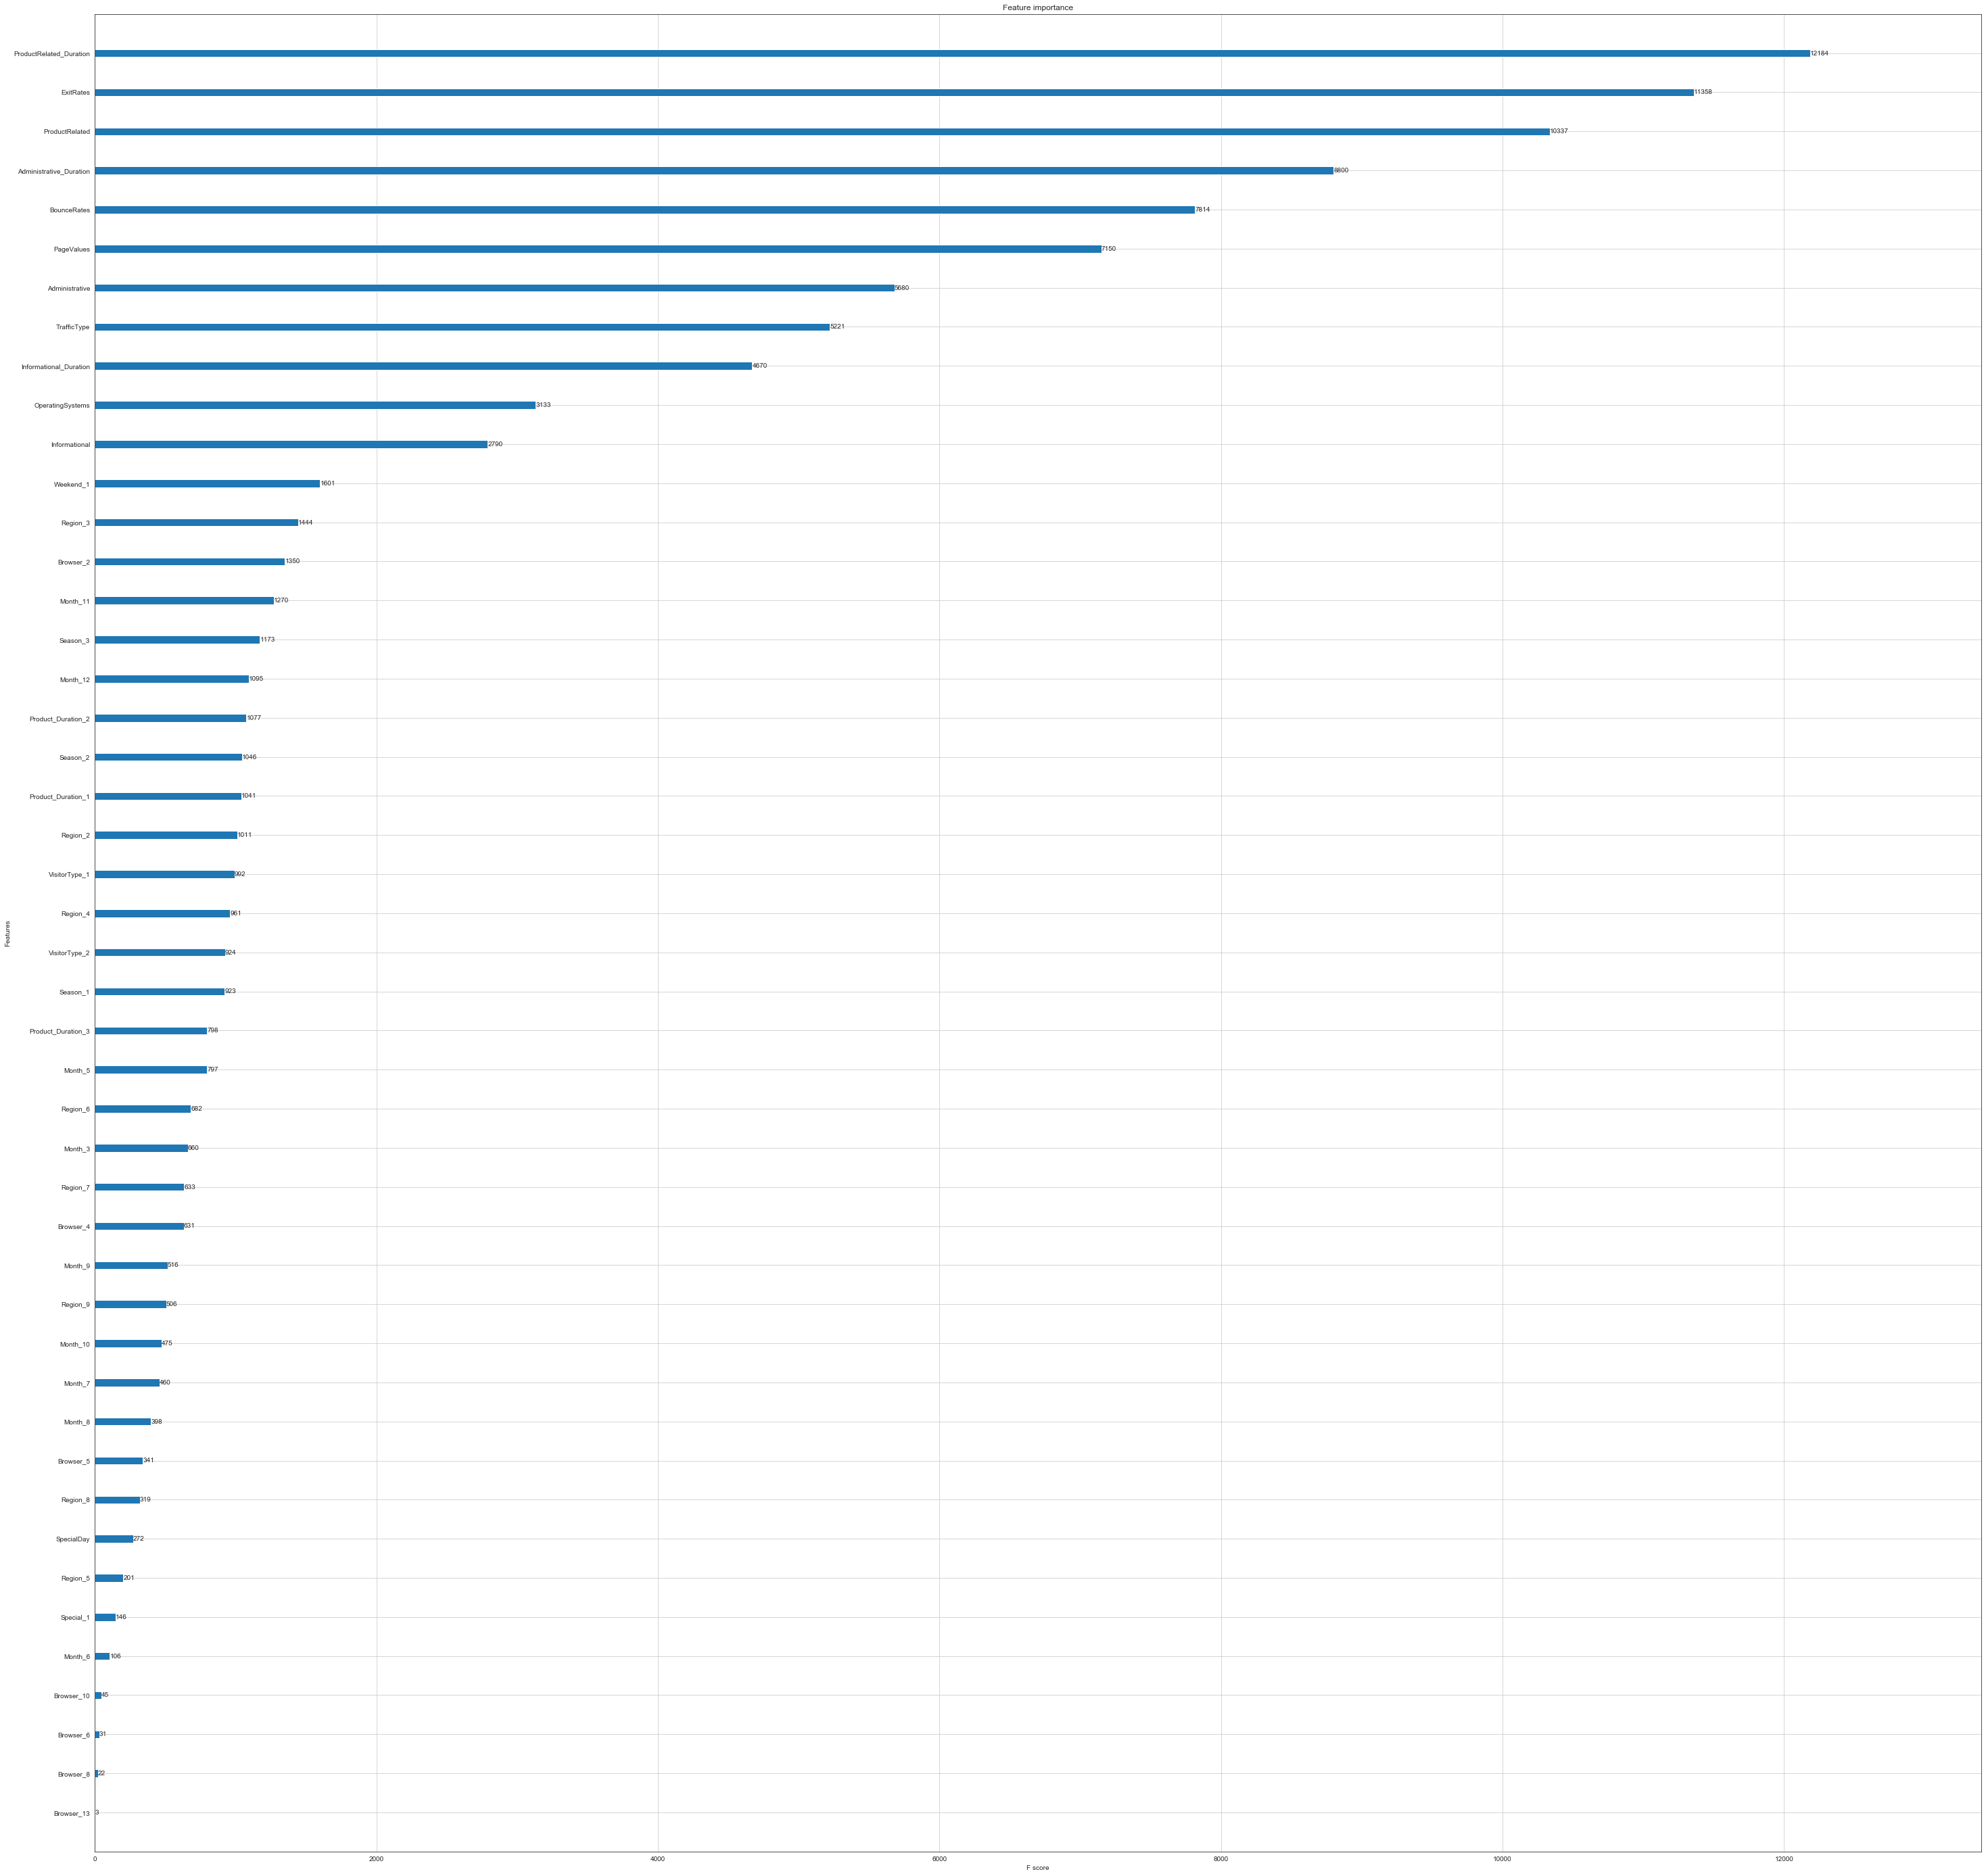

In [145]:
xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

<Figure size 576x360 with 0 Axes>

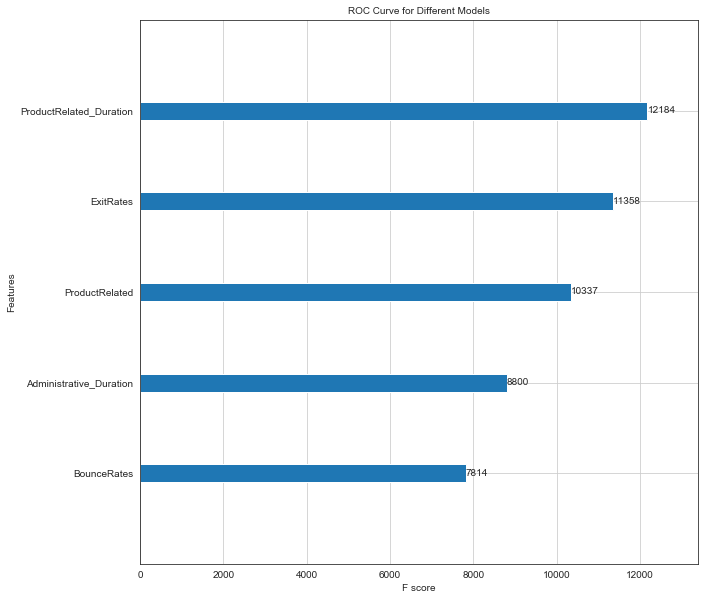

In [178]:
plt.figure(figsize = (8,5))
xgb.plot_importance(xg_clf, height=.2, max_num_features=5)
plt.rcParams['figure.figsize'] = [10, 10]
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('ROC Curve for Different Models', fontsize=10)
plt.show();

In [79]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))

    return alg
#     feat_imp = pd.Series(alg.get_booster().get_fscore())
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [64]:
train  = pd.concat([X_train, y_train], axis=1)
target = 'Revenue'


In [77]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

In [78]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

alg = modelfit(xgb1, train, predictors, target)


Model Report
Accuracy : 0.96
AUC Score (Train): 0.993575


In [129]:
xgk_preds = alg.predict(X_test)


test_f1 = f1_score(y_test, xgk_preds)
test_acc = accuracy_score(y_test, xgk_preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.900692
F1: 0.651429


In [130]:
fpr6,tpr6,thresh=roc_curve(y_test,xgk_preds)
auc6=auc(fpr6,tpr6)

## XGBoost with GridSearch

TOOK TOO LONG, SCRATCHED

In [81]:

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': [100,300,500],
              'learning_rate': [0.1,0.07,0.05,0.03,0.01],
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.5,0.45,0.4],
              'min_child_weight': [1, 2, 3]
             }

In [82]:
# initiate the Gridsearch model
gsearch1 = GridSearchCV(
    estimator = clf_xgb,
    param_grid = param_dist, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)


In [83]:
# gsearch1.fit(train[predictors],train[target])


Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 36.6min


KeyboardInterrupt: 

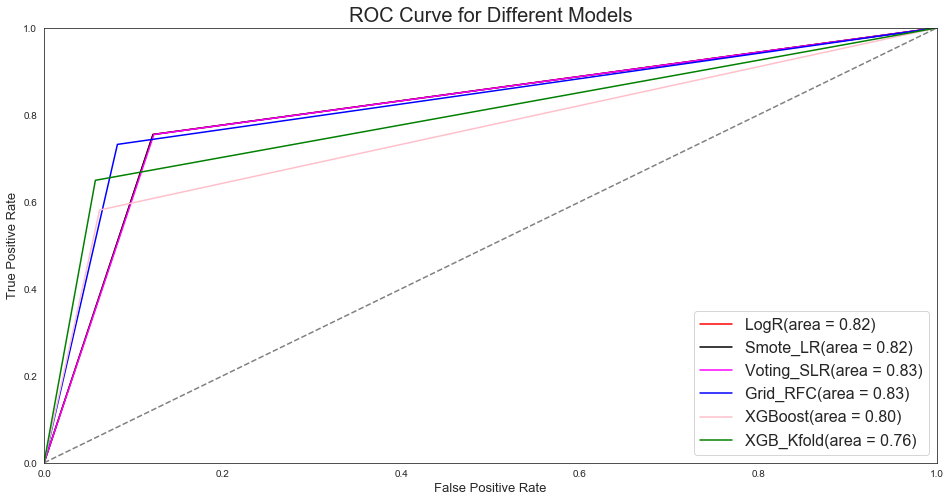

In [140]:
plt.figure(figsize = (16,8))
plt.plot(fpr1,tpr1, label='LogR(area = %0.2f)' % auc1,color='red')
plt.plot(fpr2, tpr2, label='Smote_LR(area = %0.2f)' % auc2,color='black')
plt.plot(fpr3, tpr3, label='Voting_SLR(area = %0.2f)' % auc3,color='magenta')
plt.plot(fpr4, tpr4, label='Grid_RFC(area = %0.2f)' % auc4,color='blue')
plt.plot(fpr5, tpr5, label='XGBoost(area = %0.2f)' % auc6,color='pink')
plt.plot(fpr6, tpr6, label='XGB_Kfold(area = %0.2f)' % auc5,color='green')


plt.plot([0, 1], [0, 1], 'k--',color='grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve for Different Models', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()


Looking at all of our models, it looks like the Random Forest on the SMOTE sample using GridSearchCV gave us a high F1 score and accuracy score. It was also tied with the Voting Classifier of the SMOTE Log Reg for area under curve for our ROC Curve. Because we had a high imbalance of class, if you were to make a prediction just by looking at dominant class you would be right 85% of the time. So that's why we were more interested in the F1 score in coming to our conclusion.